In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True, transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 63336205.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from google.colab import drive

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load the classifier model
import torchvision.models as models
classifier=models.resnet50(pretrained=True)
classifier.fc=nn.Sequential(
    nn.Linear(in_features=2048,out_features=1000,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1000,out_features=10,bias=True),
    #nn.LogSoftmax(dim=1)
)
model_pth='/content/drive/MyDrive/Classifier_Folder/epoch_8_fine_tuned_resnet50.pth'
classifier.load_state_dict(torch.load(model_pth))
classifier=classifier.to('cuda')
classifier.eval()

In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pandas as pd

# Download and prepare CIFAR-10 dataset
image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

cifar10_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(cifar10_data, batch_size=128, shuffle=True)

Files already downloaded and verified


In [ ]:
y_pred = []
y_true = []

import torch.nn.functional as F


with torch.no_grad():
    for images, labels in data_loader:
        images=images.to('cuda')
        labels=labels.to('cuda')
        outputs = classifier(images)
        log_probs = F.log_softmax(outputs, dim=-1)
        print(log_probs)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        #print(labels)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

流式输出内容被截断，只能显示最后 5000 行内容。
         -3.6923e+00, -2.1218e+00],
        [-2.7062e+01, -2.6149e+01, -1.9456e+01,  ..., -1.9430e+01,
         -2.9523e+01, -2.6218e+01],
        [-1.1339e+01, -9.3122e-03, -1.4171e+01,  ..., -1.4023e+01,
         -1.1353e+01, -4.7132e+00],
        ...,
        [-1.5783e+01, -1.6594e+01, -8.9441e+00,  ..., -1.1673e+01,
         -1.8180e+01, -1.6047e+01],
        [-3.7180e-03, -1.4232e+01, -5.8065e+00,  ..., -1.2983e+01,
         -7.3035e+00, -1.3577e+01],
        [-1.2782e+01, -1.2534e+01, -7.6704e+00,  ..., -7.3292e+00,
         -1.5304e+01, -1.4592e+01]], device='cuda:0')
tensor([[-1.0054e+01, -1.2067e+01, -7.4791e+00,  ..., -9.0941e+00,
         -1.2012e+01, -1.1632e+01],
        [-1.0335e+01, -1.1543e+01, -6.3247e+00,  ..., -6.2444e+00,
         -1.2521e+01, -8.4643e+00],
        [-4.2076e+00, -3.1756e-02, -1.2083e+01,  ..., -1.2588e+01,
         -5.5919e+00, -4.3837e+00],
        ...,
        [-1.1334e+01, -1.4657e-03, -1.5595e+01,  ..., -1.2665e+01,
  

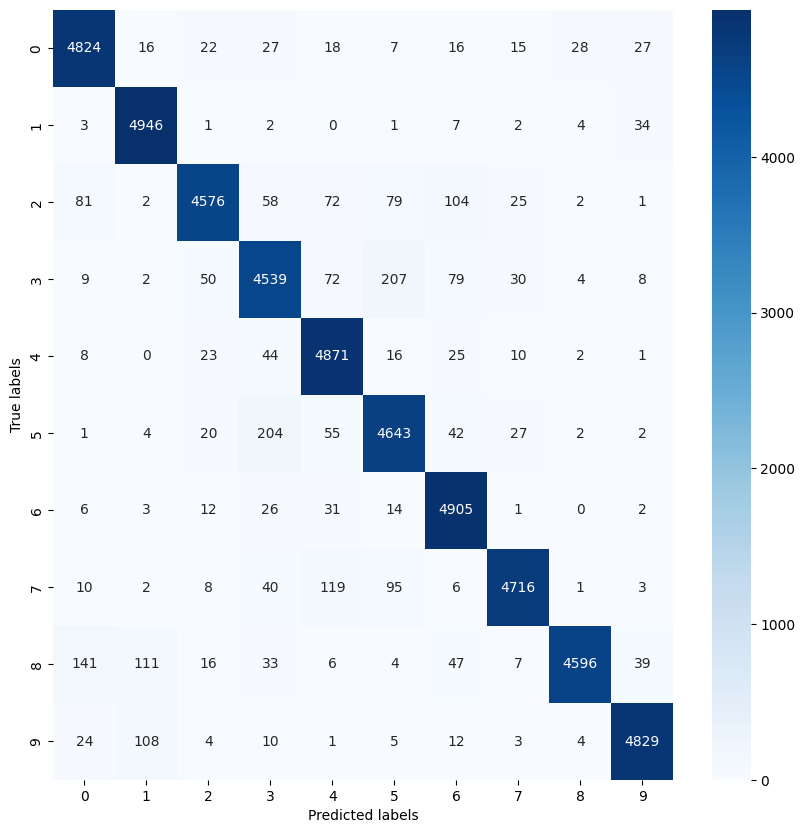

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
def evaluate_accuracy(model, test_loader):
    # 确保模型在验证模式，这对于某些层如Dropout和BatchNorm是必要的
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():  # 在评估模式下不计算梯度
        for data in test_loader:
            label_tensor=data[1]
            input_tensor=data[0]
            label_tensor=label_tensor.to('cuda')
            input_tensor=input_tensor.to('cuda')
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            print(label_tensor)
            total += label_tensor.size(0)
            correct += (predicted == label_tensor).sum().item()

    # 转换为百分比
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
accuracy=evaluate_accuracy(classifier, data_loader)
print(accuracy)

tensor([1, 5, 6, 5, 5, 4, 7, 1, 1, 0, 4, 9, 0, 3, 6, 7, 5, 9, 8, 1, 6, 7, 0, 8,
        5, 3, 2, 0, 8, 1, 7, 3, 7, 0, 2, 1, 4, 1, 8, 7, 8, 7, 3, 3, 5, 8, 0, 3,
        2, 5, 1, 8, 6, 7, 4, 5, 8, 2, 9, 3, 7, 6, 0, 7, 2, 8, 1, 8, 7, 5, 5, 3,
        8, 3, 4, 4, 7, 3, 7, 5, 9, 6, 4, 1, 7, 2, 1, 3, 0, 8, 2, 7, 1, 0, 8, 0,
        3, 1, 2, 3, 8, 7, 9, 2, 2, 6, 1, 7, 1, 8, 2, 0, 5, 3, 2, 4, 0, 8, 0, 6,
        9, 0, 0, 6, 9, 2, 0, 4], device='cuda:0')
tensor([1, 5, 6, 5, 5, 4, 7, 1, 1, 0, 4, 9, 0, 0, 6, 7, 5, 9, 8, 1, 6, 7, 0, 8,
        5, 3, 2, 0, 8, 1, 7, 3, 7, 0, 2, 1, 4, 1, 8, 7, 8, 7, 3, 3, 5, 0, 0, 3,
        2, 5, 1, 8, 6, 7, 4, 7, 8, 2, 9, 3, 7, 6, 0, 7, 2, 8, 1, 8, 7, 5, 5, 3,
        8, 3, 4, 4, 7, 0, 7, 5, 9, 6, 4, 1, 7, 2, 9, 3, 0, 8, 2, 7, 1, 0, 8, 0,
        3, 1, 2, 3, 8, 5, 9, 2, 2, 6, 1, 7, 1, 8, 2, 0, 5, 3, 2, 4, 0, 8, 0, 6,
        9, 0, 0, 6, 9, 2, 8, 4], device='cuda:0')
tensor([1, 1, 6, 7, 7, 5, 9, 4, 6, 6, 9, 4, 9, 7, 4, 0, 9, 0, 7, 8, 5, 2, 6, 8,
        5, 7, 4, 0, 